In [33]:
GPUAcc = False
try:
    import cupy as xp
    GPUAcc = True
    print("Using GPU Acceleration")
except:
    import numpy as xp
import matplotlib.pyplot as plt
from Metropolis import Metropolis_Time_Recorded, Metropolis, Metropolis2D, Metropolis2DWithRadius
import pickle

Using GPU Acceleration


In [208]:
Nspins = 8

# Jnonlocal = xp.random.normal(
#                     loc=0.0, scale=1.0, size=(Nspins, Nspins)) #xp.ones((Nspins, Nspins))
# Jnonlocal = (Jnonlocal + Jnonlocal.T)/2

Zenergy=0.0

In [209]:
def harm_greens_fnc(posx, posy,alpha):
    N = posx.shape[0]
    normalization = xp.exp(alpha)/(2*xp.pi*xp.sinh(alpha))
    x = xp.einsum("i,j->ij",posx,xp.ones(N)) 
    xT = xp.einsum("i,j->ij",xp.ones(N),posx)
    
    y = xp.einsum("i,j->ij",posy,xp.ones(N)) 
    yT = xp.einsum("i,j->ij",xp.ones(N),posy)

    term1 = -(xp.square(x - xT) + xp.square(y - yT))/(2*xp.tanh(alpha/2))
    term2 = -xp.tanh(alpha/2)*(xp.square(x + xT) + xp.square(y + yT))/2

    return normalization*xp.exp(term1 + term2)

def harm_greens_fnc_diagonal(posx, posy, alpha):
    N = posx.shape[0]
    normalization = xp.exp(alpha)/(2*xp.pi*xp.sinh(alpha))

    return normalization*xp.exp(-xp.tanh(alpha/2)*(xp.square(2.*posx) + xp.square(2.*posy))/2)

def confoncal_greens_fnc_nonlocal(posx, posy, alpha):
    return harm_greens_fnc(posx, posy, alpha + 1j*xp.pi/2) + harm_greens_fnc(posx, posy, alpha - 1j*xp.pi/2) 

def confoncal_greens_fnc_local(posx, posy, alpha):
    return harm_greens_fnc_diagonal(posx, posy, alpha) + harm_greens_fnc_diagonal(posx, posy, alpha - 1j*xp.pi)

def generate_Js(pos_sigma = 0.2):
    posx = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)
    posy = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)

    Jnonlocal = xp.real(confoncal_greens_fnc_nonlocal(posx,posy, 0.02))
    Jlocal = xp.real(confoncal_greens_fnc_local(posx, posy, 2*0.02))
    return Jnonlocal, Jlocal

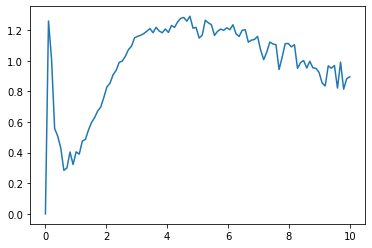

In [207]:
sigma = xp.linspace(0.0,10.0,100)
std = xp.zeros(100)
for i in range(100):
    Jnonlocal, Jlocal = generate_Js(pos_sigma=sigma[i])
    std[i] = xp.std(Jlocal)
plt.plot(sigma.get(), std.get())

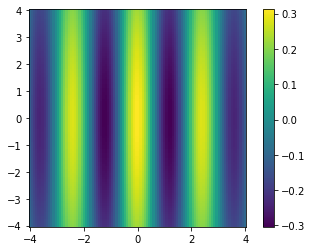

In [136]:
x = xp.linspace(-4.0,4.0,100)
y = xp.linspace(-4.0,4.0,100)
X,Y = xp.meshgrid(x,y)
Z = 0.*1j*X

xpr = 1.3
ypr = 0.0

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        temp = confoncal_greens_fnc_nonlocal(xp.array([X[i,j].get(),xpr]), xp.array([Y[i,j].get(),ypr]), 0.02)
        Z[i,j] = temp[0,1]
plt.pcolor(X.get(),Y.get(),xp.real(Z).get())
plt.gca().set_aspect('equal')
plt.colorbar()

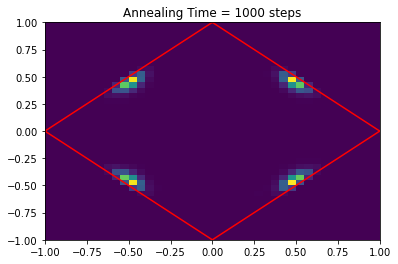

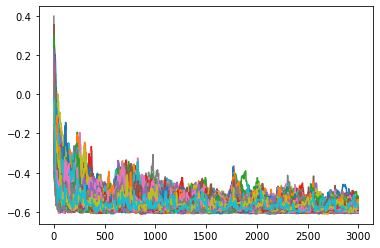

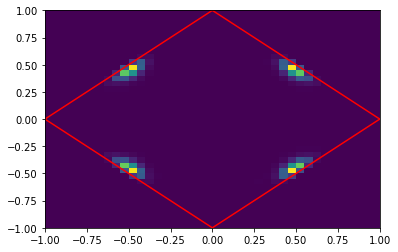

In [219]:
pos_sigma=2.0
posx = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)
posy = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)

Jnonlocal = xp.real(confoncal_greens_fnc_nonlocal(posx,posy, 0.02))
Jlocal = xp.real(confoncal_greens_fnc_local(posx, posy, 2*0.02))

Tc = max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

N = 2*max(Jlocal)+2*Tc

Jnonlocal = Jnonlocal/N
Jlocal = Jlocal/N

Tfinal = 0.01*Tc
AnnealHigh = Tfinal*1.5
AnnealT = 1000

met = Metropolis2D(Jnonlocal, Tfinal, steps=int(3*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=500, AnnealHigh=AnnealHigh)
final_state = met.run()
fig, ax = plt.subplots()
ax.set_title(f"Annealing Time = {AnnealT} steps")
met.plot_overlap_distribution(ax=ax)
met.plot_energy_record()
met.plot_overlap_distribution()
plt.show()

In [ ]:
Jlocals = xp.load("ConfocalJlocals.npy")
Jnonlocals = xp.load("ConfocalJnonlocals.npy")

gs = [0.25,0.5,1.0,1.25,2.0]



for g in gs:
    for i in range(Jlocal.shape[0]):
        Tc = max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

        N = 2*max(Jlocal)+2*Tc

        Jnonlocal = Jnonlocal/N
        Jlocal = Jlocal/N

        Tfinal = 0.01*Tc
        AnnealHigh = Tfinal*1.5
        AnnealT = 500

        met = Metropolis2D(Jnonlocal, Tfinal, steps=int(3*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=1000, AnnealHigh=AnnealHigh)
        final_state = met.run()
        fig, ax = plt.subplots()
        ax.set_title(f"Annealing Time = {AnnealT} steps")
        met.plot_overlap_distribution(ax=ax)
        met.plot_energy_record()
        met.plot_overlap_distribution()
        plt.show()

In [304]:
Jlocals.shape[0]

10

In [ ]:
for AnnealT in [50., 100., 500., 1000., 10000., 15000., 20000.]:
    met = Metropolis(Jnonlocal, Jlocal, Zenergy, Tfinal, steps=int(3*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=500, AnnealHigh=AnnealHigh)
    final_state = met.run()
    fig, ax = plt.subplots()
    ax.set_title(f"Annealing Time = {AnnealT} steps")
    met.plot_overlap_distribution(ax=ax)
    met.plot_energy_record()
    plt.show()

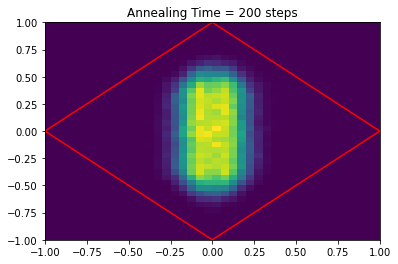

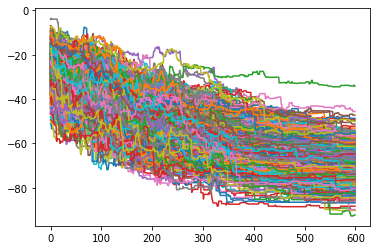

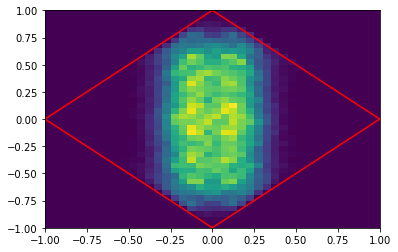

In [6]:
for AnnealT in [200]:
    met = Metropolis2DWithRadius(Jnonlocal, Jlocal, Tfinal, steps=int(3*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=500, AnnealHigh=AnnealHigh)
    final_state = met.run()
    fig, ax = plt.subplots()
    ax.set_title(f"Annealing Time = {AnnealT} steps")
    met.plot_overlap_distribution(ax=ax)
    met.plot_energy_record()
    met.plot_angle_overlap_distribution()
    plt.show()

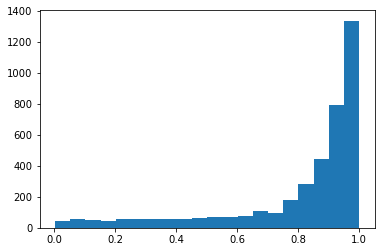

In [7]:
plt.hist(met.curr_state[:,:,0].flatten().get(), bins=20)
plt.show()

In [10]:
max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

array(3.63753373)

In [12]:
max(xp.linalg.eigvalsh(Jnonlocal))/max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

array(0.67562744)

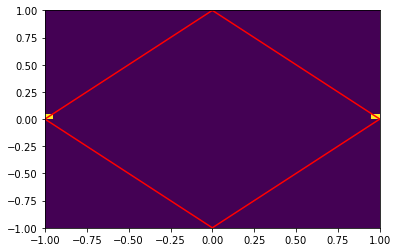

In [61]:
Nspins=8;Nrepl=500
met = Metropolis(Jnonlocal, Jlocal, Zenergy, Tfinal, steps=int(8*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=Nrepl, AnnealHigh=AnnealHigh)
# met.curr_state = xp.array([[[1.0, xp.pi/2.0, xp.pi/3.0]],[[1.0, xp.pi/2.0, 0.0]]])
met.curr_state = xp.moveaxis(xp.array([xp.ones((Nrepl,Nspins)), xp.ones((Nrepl,Nspins)), xp.pi*xp.einsum("a,b->ab",xp.abs(xp.random.rand(Nrepl) > 0.5), xp.ones(Nspins))]), 0, 2)
met.plot_angle_overlap_distribution()

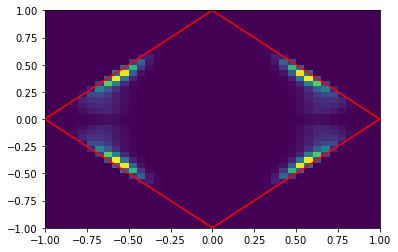

In [305]:
with open("MetropolisRuns/2component/J0g=0.25T=0.05Tc.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_overlap_distribution()

In [292]:
loadedmet.Jnonlocal

array([[-0.00374402, -0.02807214,  0.0010209 ,  0.02606124, -0.01853942,
         0.01279803, -0.00569422,  0.00469676],
       [-0.02807214, -0.0233886 , -0.01967226, -0.02804612,  0.01965105,
        -0.01196591, -0.0127998 , -0.02447578],
       [ 0.0010209 , -0.01967226,  0.01211801, -0.00139708,  0.01743657,
         0.01013923,  0.01778654,  0.00793088],
       [ 0.02606124, -0.02804612, -0.00139708, -0.01993447, -0.01051729,
         0.00869763, -0.02557603,  0.00403216],
       [-0.01853942,  0.01965105,  0.01743657, -0.01051729,  0.01402848,
        -0.02997643,  0.0241369 , -0.02538518],
       [ 0.01279803, -0.01196591,  0.01013923,  0.00869763, -0.02997643,
        -0.02763681,  0.02525687, -0.01384784],
       [-0.00569422, -0.0127998 ,  0.01778654, -0.02557603,  0.0241369 ,
         0.02525687, -0.02346409, -0.01717207],
       [ 0.00469676, -0.02447578,  0.00793088,  0.00403216, -0.02538518,
        -0.01384784, -0.01717207,  0.01494097]])

In [291]:
loadedmet.Jlocal

array([0.31979907, 0.40565931, 0.15539339, 0.39279041, 0.41609881,
       0.35278563, 0.35653941, 0.26134556])

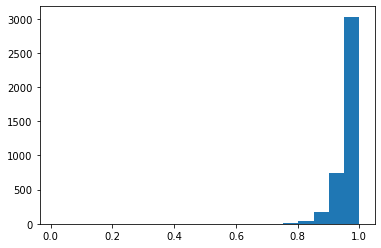

In [7]:
loadedmet.plot_radius_hist()

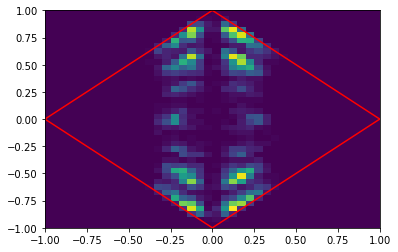

In [4]:
with open("MetropolisRuns/3component/Ze=1.0e-01,T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

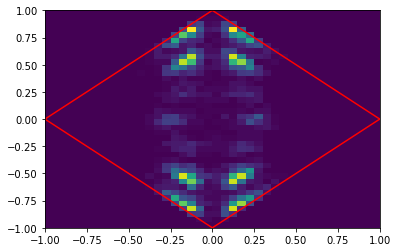

In [8]:
with open("MetropolisRuns/3component/Ze=1.0e+00,T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

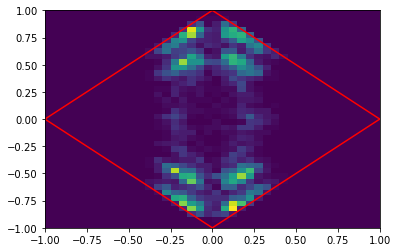

In [9]:
with open("MetropolisRuns/3component/Ze=1.0e+01,T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

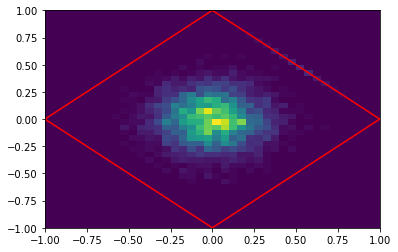

In [10]:
with open("MetropolisRuns/3component/Ze=1.0e+02,T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

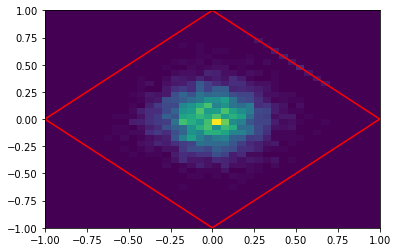

In [11]:
with open("MetropolisRuns/3component/Ze=1.0e+03,T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

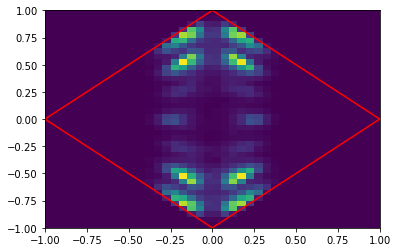

In [12]:
with open("MetropolisRuns/3component/Ze=1.00e+01,T=5.0e-02.pickle", "rb") as f:
        loadedmet = pickle.load(f)
loadedmet.plot_angle_overlap_distribution()

Text(0.5, 1.0, 'T = 0.05 $T_c$')

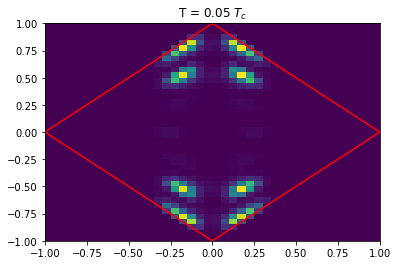

In [19]:
with open("MetropolisRuns/2component/T=1.2e-01.pickle", "rb") as f:
        loadedmet = pickle.load(f)
fig,ax=plt.subplots()
loadedmet.plot_overlap_distribution(ax)
ax.set_title("T = 0.05 $T_c$")

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


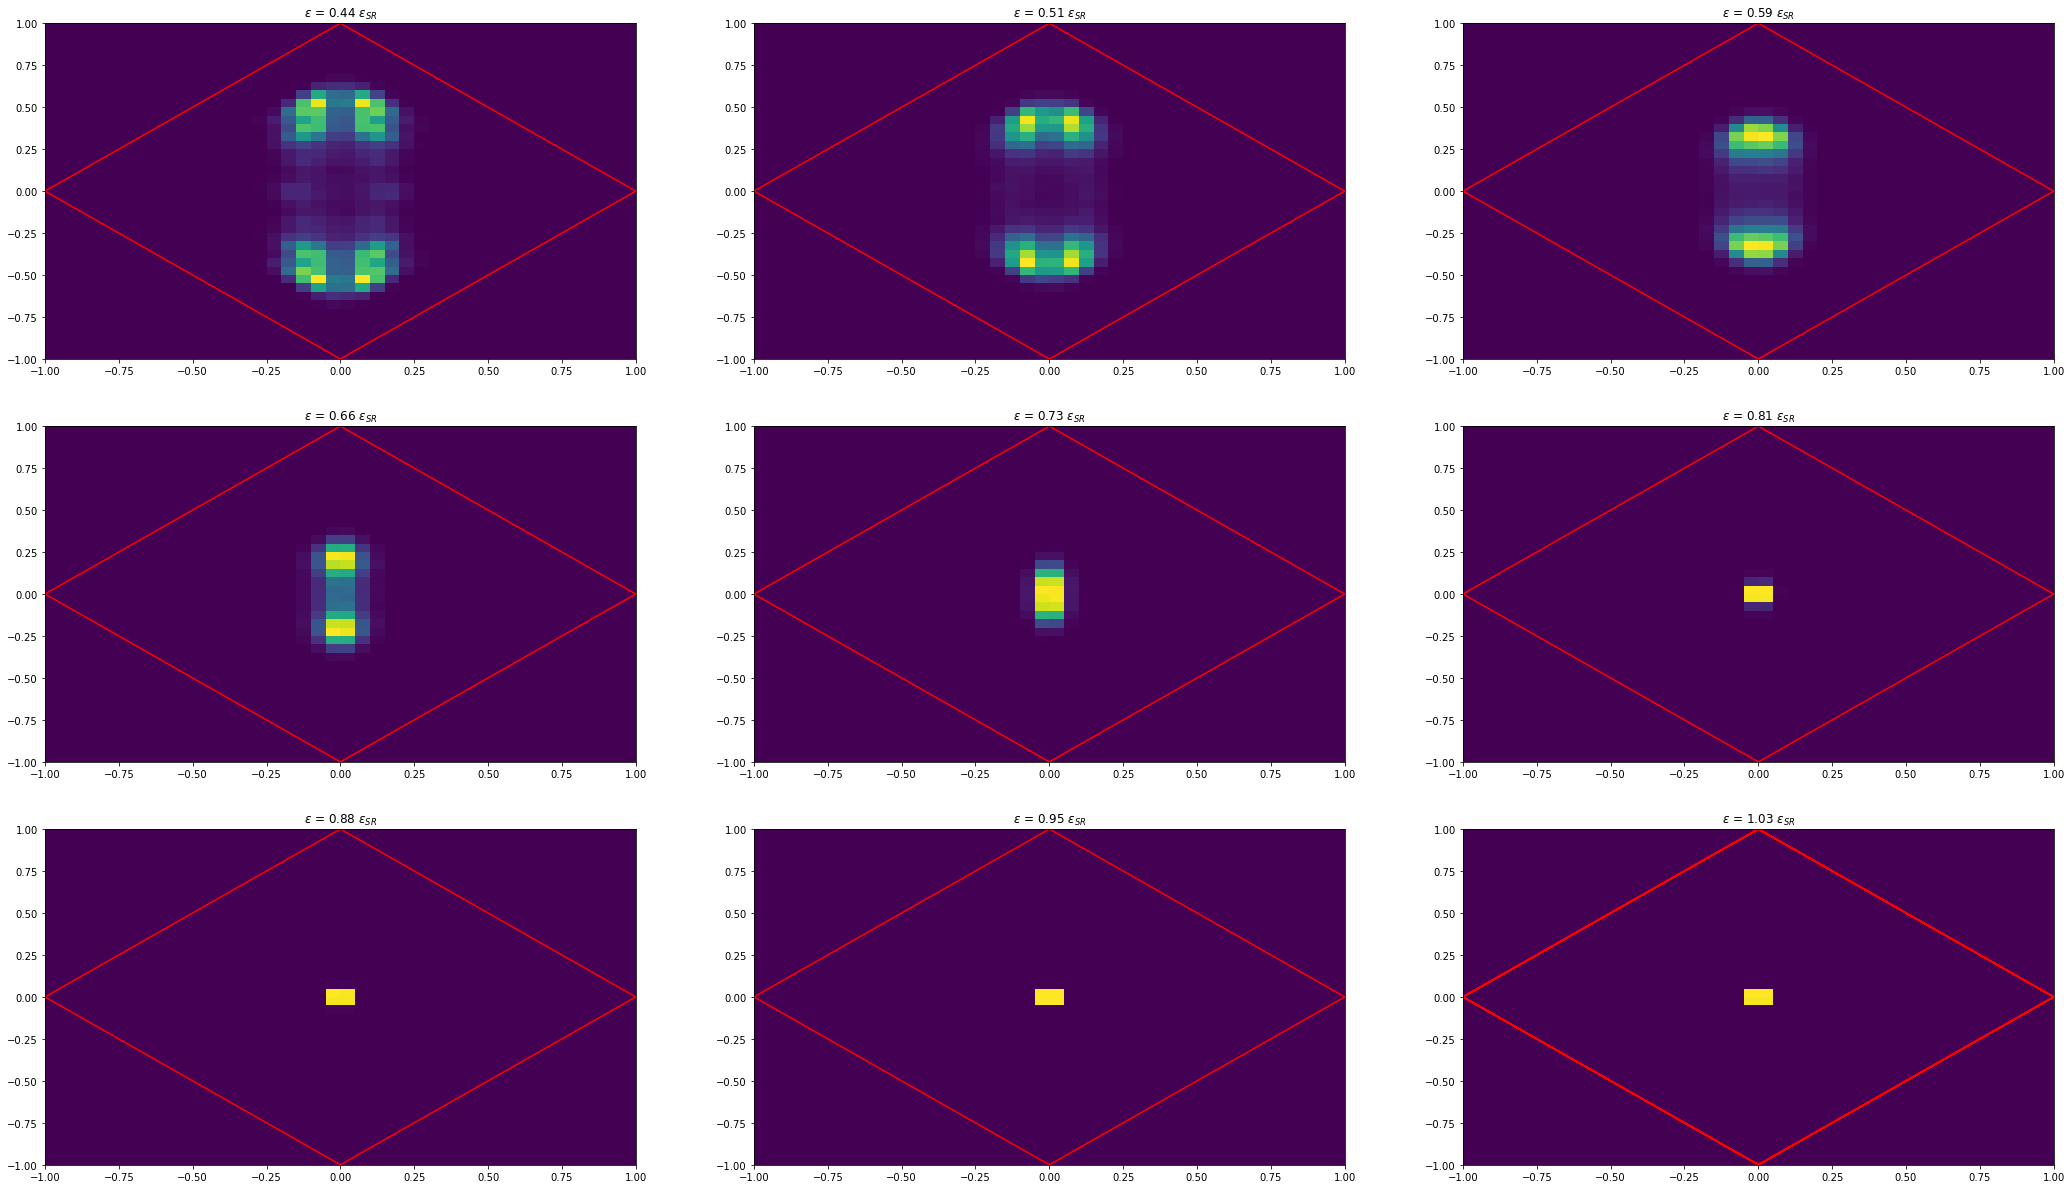

In [36]:
Zenergies = [12.,14.,16.,18.,20.,22.,24.,26.,28.]
fig, axs = plt.subplots(3,len(Zenergies)//3)
fig.set_figwidth(4*len(Zenergies))
fig.set_figheight(7*3)

epsilon_c = 2*10.0 + 2*max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

for i in range(len(Zenergies)):
        with open(f"MetropolisRuns/3component/Ze={Zenergies[i]:.2e},T=5.0e-02.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//(len(Zenergies)//3), i % (len(Zenergies)//3))
        ax = axs[i//(len(Zenergies)//3), i % (len(Zenergies)//3)]
        loadedmet.plot_overlap_distribution(ax=ax)
        ax.set_title("$\epsilon$" + f" = {Zenergies[i]/epsilon_c:.2f}"+" $\epsilon_{SR}$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

FileNotFoundError: [Errno 2] No such file or directory: 'MetropolisRuns/2component/J0g=0.25T=0.01Tc.pickle'

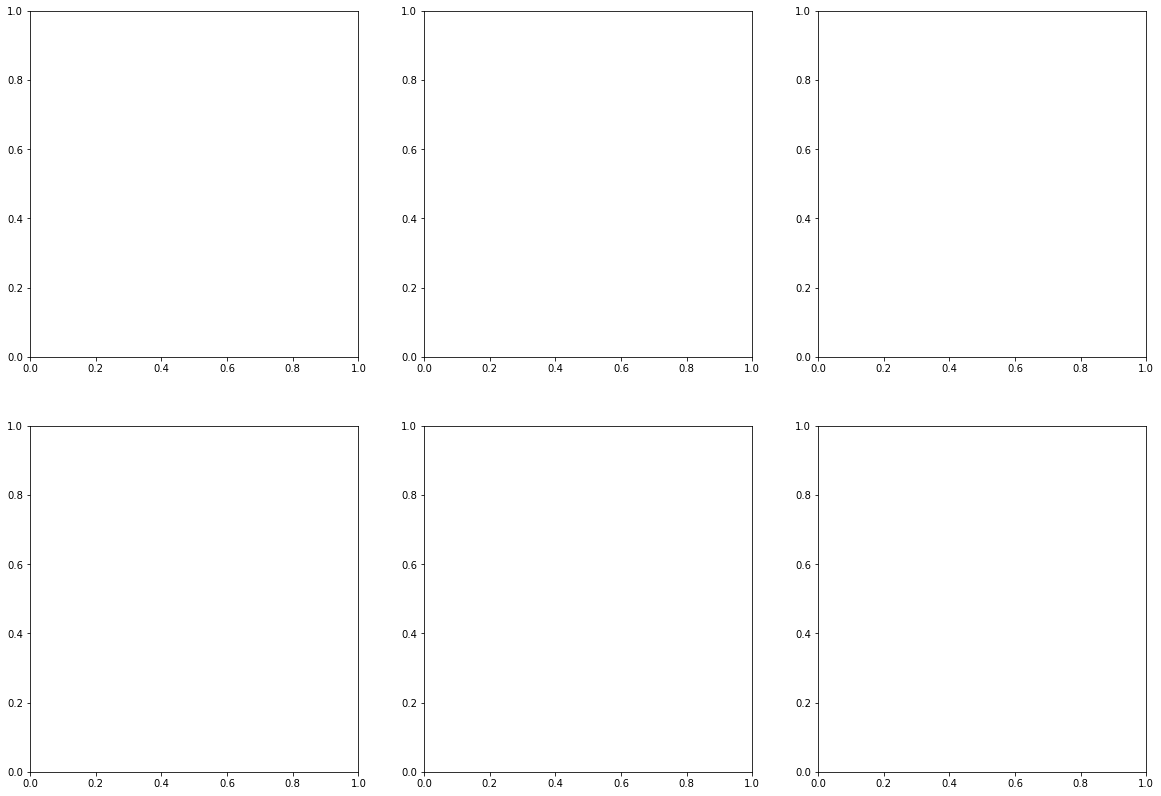

In [337]:
gs = [0.25,0.5,1.0,1.25,2.0]

fig, axs = plt.subplots(2,3)
fig.set_figwidth(4*5)
fig.set_figheight(7*2)

for i in range(len(gs)):
        with open(f"MetropolisRuns/2component/J0g={gs[i]:.2f}T=0.01Tc.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//3, i % 3)
        ax = axs[i//3, i % 3]
        loadedmet.plot_overlap_distribution(ax=ax)
        ax.set_title(f"g = {gs[i]:.2f}"+" $g_c$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

0 0
0 1
0 2
1 0
1 1


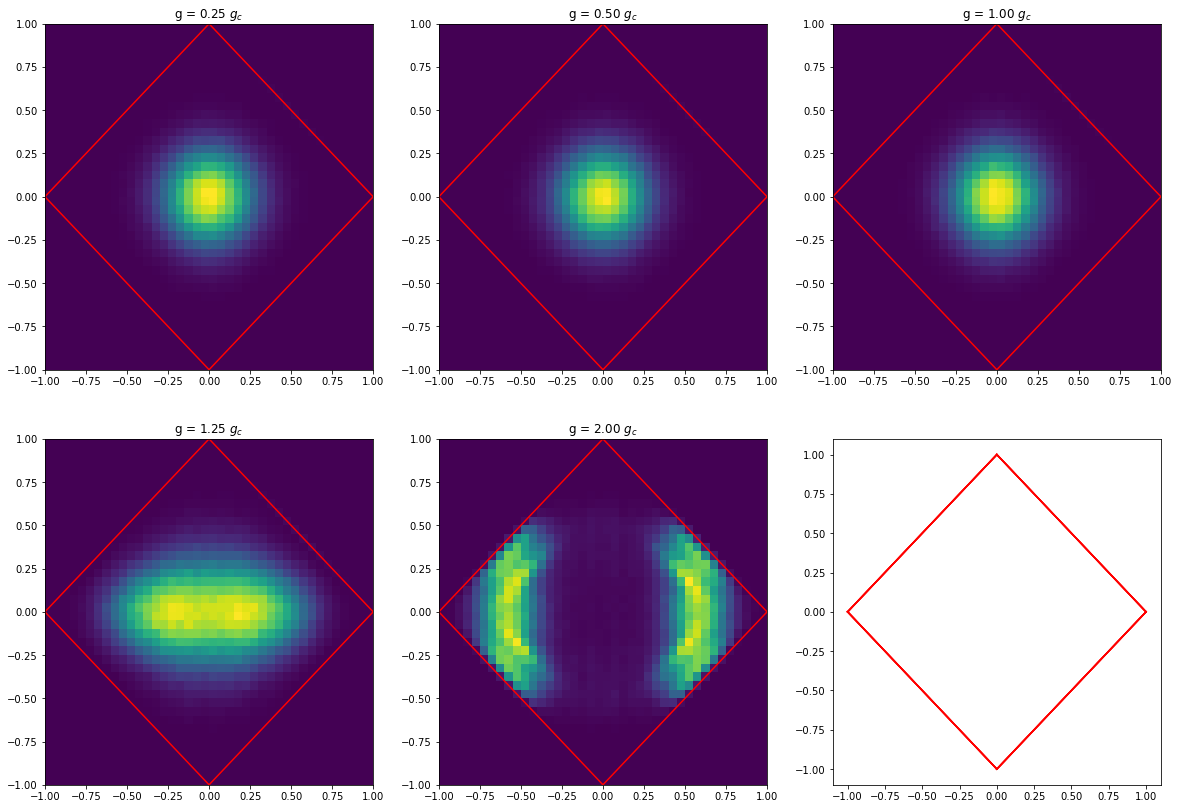

In [351]:
gs = [0.25,0.5,1.0,1.25,2.0]

fig, axs = plt.subplots(2,3)
fig.set_figwidth(4*5)
fig.set_figheight(7*2)

for i in range(len(gs)):
        with open(f"MetropolisRuns/3component/J9g={gs[i]:.2f}T=0.01Tc.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//3, i % 3)
        ax = axs[i//3, i % 3]
        loadedmet.plot_angle_overlap_distribution(ax=ax)
        ax.set_title(f"g = {gs[i]:.2f}"+" $g_c$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

In [22]:
2*10.0 + 2*max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

array(27.27506745)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


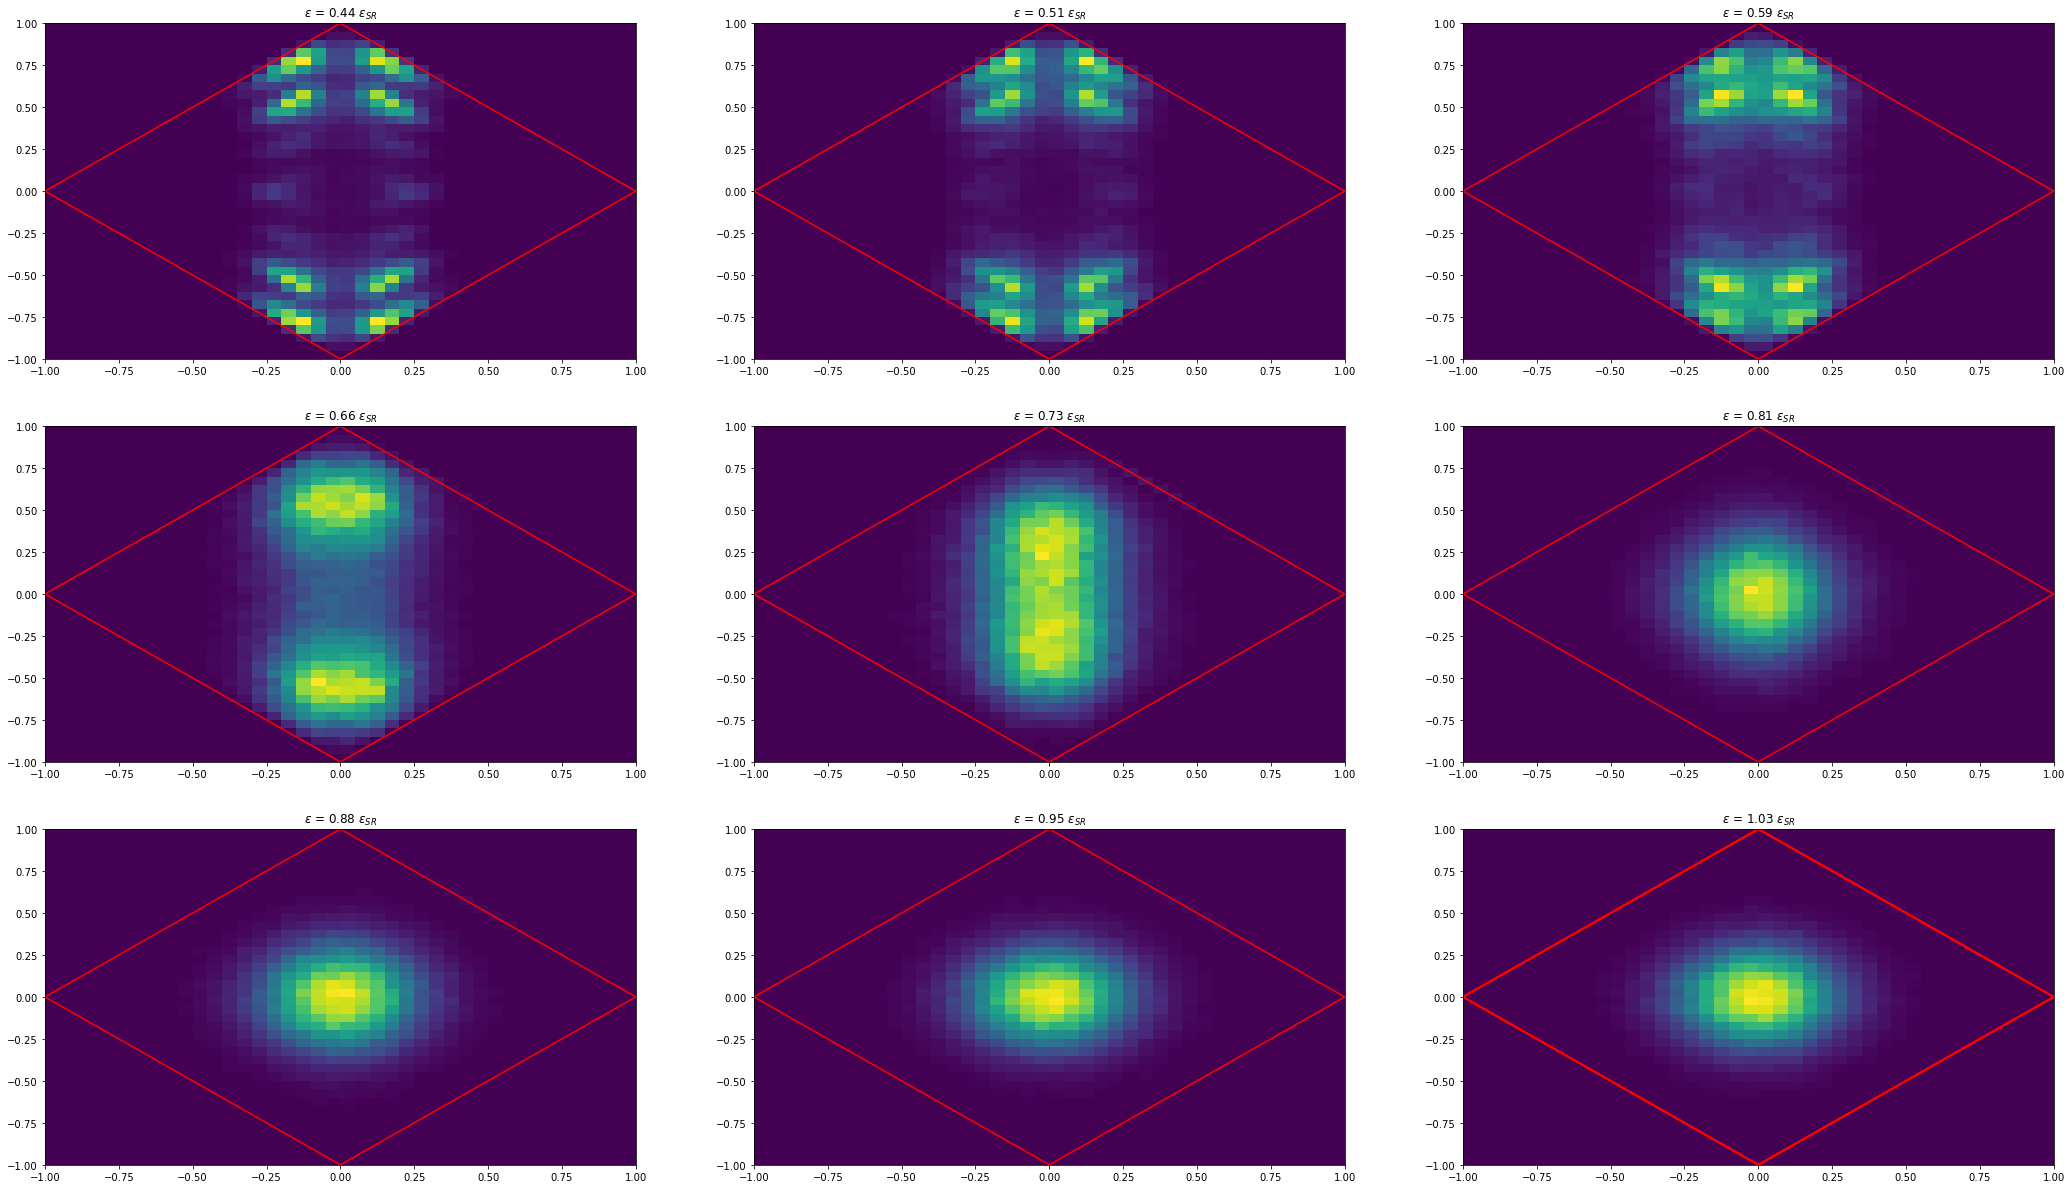

In [34]:
Zenergies = [12.,14.,16.,18.,20.,22.,24.,26.,28.]
fig, axs = plt.subplots(3,len(Zenergies)//3)
fig.set_figwidth(4*len(Zenergies))
fig.set_figheight(7*3)

epsilon_c = 2*10.0 + 2*max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

for i in range(len(Zenergies)):
        with open(f"MetropolisRuns/3component/Ze={Zenergies[i]:.2e},T=5.0e-02.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//(len(Zenergies)//3), i % (len(Zenergies)//3))
        ax = axs[i//(len(Zenergies)//3), i % (len(Zenergies)//3)]
        loadedmet.plot_angle_overlap_distribution(ax=ax)
        ax.set_title("$\epsilon$" + f" = {Zenergies[i]/epsilon_c:.2f}"+" $\epsilon_{SR}$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

0 0
0 1
0 2
1 0
1 1
1 2


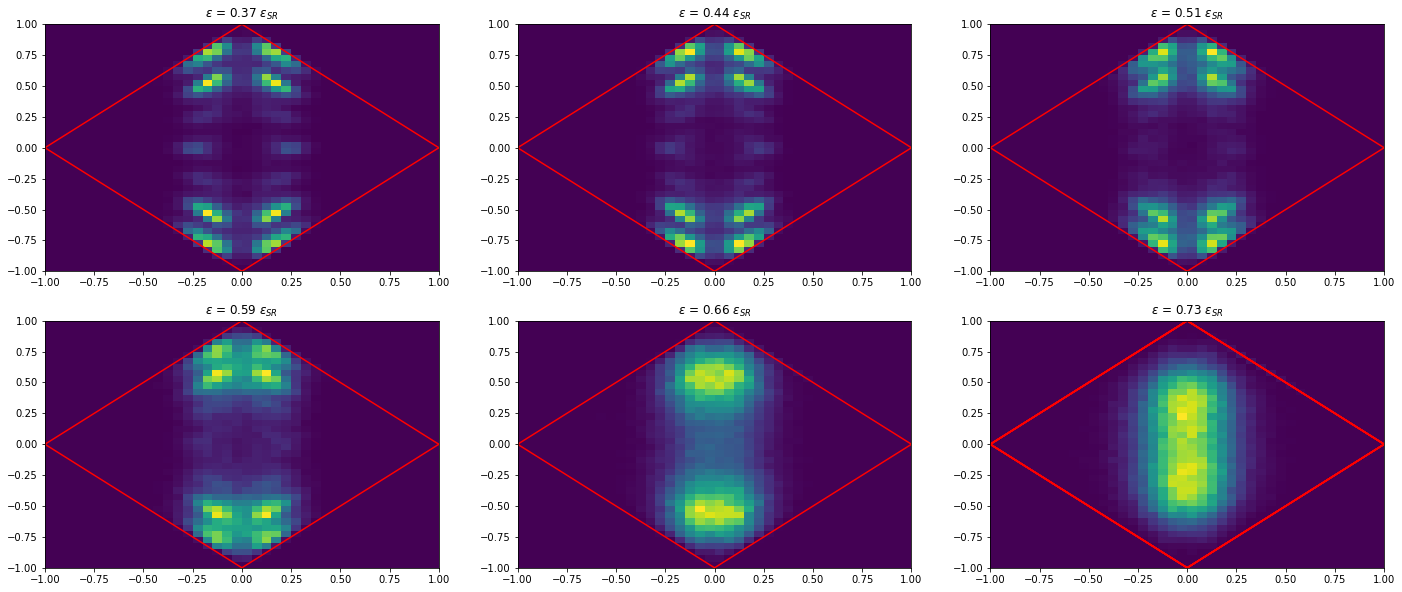

In [41]:
Zenergies = [10., 12.,14.,16.,18.,20.]
fig, axs = plt.subplots(2,len(Zenergies)//2)
fig.set_figwidth(4*len(Zenergies))
fig.set_figheight(5*2)

epsilon_c = 2*10.0 + 2*max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

for i in range(len(Zenergies)):
        with open(f"MetropolisRuns/3component/Ze={Zenergies[i]:.2e},T=5.0e-02.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//(len(Zenergies)//2), i % (len(Zenergies)//2))
        ax = axs[i//(len(Zenergies)//2), i % (len(Zenergies)//2)]
        loadedmet.plot_angle_overlap_distribution(ax=ax)
        ax.set_title("$\epsilon$" + f" = {Zenergies[i]/epsilon_c:.2f}"+" $\epsilon_{SR}$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

0 0
0 1
0 2
1 0
1 1
1 2


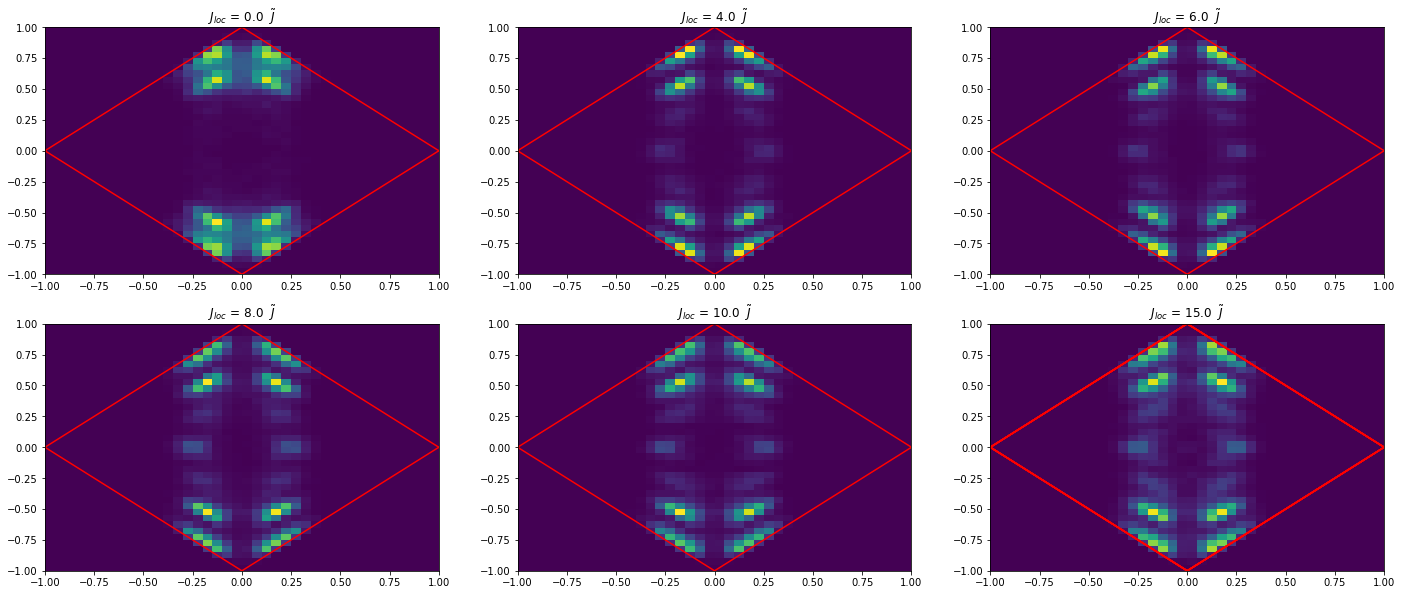

In [7]:
Jlocals = [0., 4., 6., 8.,10.,15.]
fig, axs = plt.subplots(2,len(Jlocals)//2)
fig.set_figwidth(4*len(Jlocals))
fig.set_figheight(5*2)


for i in range(len(Jlocals)):
        with open(f"MetropolisRuns/3component/Jlocal={Jlocals[i]:.2e},Ze=0.00e+00,T=5.0e-02.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//(len(Jlocals)//2), i % (len(Jlocals)//2))
        ax = axs[i//(len(Jlocals)//2), i % (len(Jlocals)//2)]
        loadedmet.plot_angle_overlap_distribution(ax=ax)
        ax.set_title("$J_{loc}$" + f" = {Jlocals[i]} "+" $\\tilde{J}$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

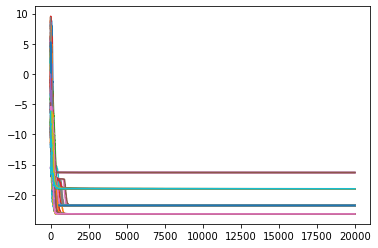

In [30]:
loadedmet.plot_energy_record()

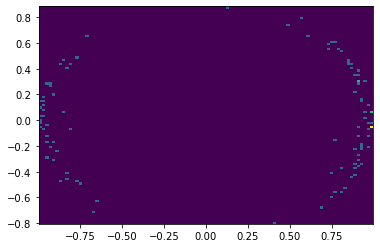

In [10]:
loadedmet.plot_single_spin_hist(5)